<a href="https://colab.research.google.com/github/DanielGreiner/Masterarbeit/blob/main/Model_reactor_1D_steady_state_isothermal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# reactions

  \begin{array}{lll}
  \text{Methanol steam reforming (MSR):}&\kern 3pc CH_3OH_{(g)}+H_2O_{(g)}\kern 0.5pc{\overset{k_{1, eff}}{\rightleftharpoons}}\kern 0.5pc 3H_{2(g)}+CO_{2(g)}&\kern 3pc\Delta_r H_{m}^{o}= + 49\enspace \frac{kJ}{mol} \\
  \text{Methanol decomposition (MD):}&\kern 3pc CH_3OH_{(g)}\kern 0.5pc {\overset{k_{2, eff}}{\rightleftharpoons}}\kern 0.5pc 2H_{2(g)}+CO_{(g)}&\kern 3pc\Delta_r H_{m}^{o}= + 91\enspace \frac{kJ}{mol} \\
  \end{array}


# load libraries

In [165]:
# @title import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import torch as to
from scipy.integrate import odeint

In [166]:
# @title check library versions
print("tensorflow:" + str(tf.__version__))
print("numpy:" + str(np.__version__))
print("pandas:" + str(pd.__version__))
#print("torch:" + str(to.__version__))

tensorflow:2.13.0
numpy:1.23.5
pandas:1.5.3


# setup

**Indexing in arrays:**

\begin{array}{lllll}
H_2 & H_2O & CO & CO_2 & CH_3OH \\
0 & 1 & 2 & 3 & 4 \\
\end{array}

In [167]:
# @title reactor constants

'''
Define all reactor specific constants and calculate size of finite differential for numerical integration
'''

L_R = 0.720               # reactor length [m]
d_R = 0.133               # reactor diameter [m]
r_R = d_R/2               # reactor radius [m]
A_R = np.pi*np.power(r_R, 2, dtype=float)                 # reactor crossectional area [a.u.]
V_R = A_R*L_R             # reactor volume [m^3]
m_cat = 7950 / 1000       # catalyst mass [kg]
dens_cat_part = 3.28426/np.power(10, 3, dtype=float)      # catalyst particle density [kg m^-3]
dens_cat = m_cat/V_R      # catalyst density [kg m^-3]
p_in = 1                  # inlet pressure [bar]
n_Flow_total = 8.36812    # inlet molecular flowrate [mol h^-1]
x_MeOH_in = 0.5           # inlet molefraction methanol
x_H2O_in = 0.5            # inlet molefraction water
n_Flow_in_MeOH = x_MeOH_in * n_Flow_total         # inlet molecular flowrate methanol [mol h^-1]
n_Flow_in_H2O = x_H2O_in * n_Flow_total           # inlet molecular flowrate water [mol h^-1]
m_cat_0 = 0               # starting mass of catalyst [kg] !! typically 0
steps = 10             # number of steps in numerical calculation
dm_cat = (m_cat-m_cat_0)/steps                            # finite differential for numerical integration
m_cat_span = np.arange(m_cat_0, m_cat + dm_cat, dm_cat)   # range of mass segments for integration and plotting
R = 8.314                 # universal gas constant [J mol-1 K-1]


# segment to test constants

#print(dm_cat)
#print(m_cat_span)
#print(len(Vspansplit))
#print(stepssplit)
#print(VFlow)
#print(n_Flow_in_MeOH)

In [168]:
# @title Initial concentrations
'''
setup initial concentrations in an IC array:
'''

n0_H2 = 0                       # [kmol h^-1]
n0_H2O = n_Flow_in_H2O/1000     # [kmol h^-1]
n0_CO = 0                       # [kmol h^-1]
n0_CO2 = 0                      # [kmol h^-1]
n0_MeOH = n_Flow_in_MeOH/1000   # [kmol h^-1]

# P0_H2 = 0                     # [bar]
# P0_H2O = p_in*x_MeOH_in       # [bar]
# P0_CO = 0                     # [bar]
# P0_CO2 = 0                    # [bar]
# P0_MeOH = p_in*x_H2O_in       # [bar]

IC = np.array([n0_H2, n0_H2O, n0_CO, n0_CO2, n0_MeOH, m_cat_0])
# IP = np.array([P0_H2, P0_H2O, P0_CO, P0_CO2, P0_MeOH, m_cat_0])


In [169]:
# @title kinetics data

'''
setup kinetics data in arrays, includes S-Kinetics for the MSR and MD reactions respectively
includes activation energies, k0 and exponents for rate of reaction calculation using a modified arrhenius equation
'''

T0 = 150 + 273    # T0 to calculate arrhenius' rate of reaction constant k [K]
n = 1             # exponent in arrhenius equation

#BiCat
#MSR
k0_MSR_S = 8.5*np.power(10, -7, dtype=float)       # k0 for arrhenius[kmol kg^-1 h^-1 Pa^-b]
EA_MSR_S = 54329              # activation energy [J mol-1]
b_MeOH_MSR_S = 0.573          # rate of reaction exponent for methanol
b_H2O_MSR_S = 0.050           # rate of reaction exponent for water

MSR = np.array(
    [k0_MSR_S, EA_MSR_S, b_MeOH_MSR_S, b_H2O_MSR_S]
)

#MD
k0_MD_S = 1.1*np.power(10, -11, dtype=float)        # [kmol kg^-1 h^-1 Pa^-b]
EA_MD_S = 132540              # [J mol-1]
b_MeOH_MD_S = 1.114

MD = np.array (
    [k0_MD_S, EA_MD_S, b_MeOH_MD_S]
)

# array for stoichiometric coefficients
ny = np.array(
    [[3, -1, 0, 1, -1],
    [2, 0, 1, 0, -1]]
)


# testing block for kinetics arrays


#print(MSR)
#print(MD)
#print(ny)

# PFTR isothermal and steady state

ODE by mass catalyst:

$\frac{d\dot{n_x}}{dm_{cat}}$=$R_x$

In [170]:
# @title reaction functions

def ReakFun (P, T, VFlow):
  '''
  calculates the rate of reaction for each component for MSR and MD reactions with respect to the selected catalytic system through indexing
  '''
  # creates new empty concentration array for the components and assigns components to index
  dP=np.zeros(len(P))

  for j in range(5):
    P[j] = P[j] * R * T * 1000 / VFlow

  P_H2 = P[0]
  P_H2O = P[1]
  P_CO = P[2]
  P_CO2 = P[3]
  P_MeOH = P[4]
  m_cat_x = P[5]

  # calculates the rate of reaction for each reaction pathway and every catalyst setup
  rMSR = MSR[0] *np.power((T/T0), n, dtype=float)*np.exp((-MSR[1]/R)*(1/T-1/T0), dtype=float)
  rMSR *= np.power(P_MeOH, MSR[2], dtype=float)*np.power(P_H2O, MSR[3], dtype=float)


  rMD = MD[0]*np.power((T/T0), n, dtype=float)*np.exp((-MD[1]/R)*(1/T-1/T0), dtype=float)
  rMD *= np.power(P_MeOH, MD[2], dtype=float)

  # calculates slope of change for each component and returns the result
  dP[0] = (rMSR*ny[0, 0] + rMD*ny[1, 0])
  dP[1] = (rMSR*ny[0, 1] + rMD*ny[1, 1])
  dP[2] = (rMSR*ny[0, 2] + rMD*ny[1, 2])
  dP[3] = (rMSR*ny[0, 3] + rMD*ny[1, 3])
  dP[4] = (rMSR*ny[0, 4] + rMD*ny[1, 4])
  dP[5] = 1
  return dP


In [171]:
# @title euler's method

def EulFun (y, T, VFlow):
  '''
  uses eulers method to calculate the change in concentration given the slope
  '''

  # creates empty concentration array and inputs the initial conditions as the first data point
  ytemp = np.zeros([len(m_cat_span), len(IC)])
  ytemp[0,:] = y

  for i in range(steps):
    y = np.transpose(ytemp[i, :])
    temp = y

    dy = ReakFun(y, T, VFlow)

    for j in range(5):
        temp[j] = temp[j] / R / T / 1000 * VFlow
    ytemp[i+1, :] = temp + dy*dm_cat

    for j in range(5):
      if ytemp[i+1, j] <= 0:
        ytemp[i+1, j] = 0
  for j in range(5):
    ytemp[:, j] = ytemp[:, j] * R * T / VFlow / 100

  # transposes last set of concentrations into a vector to input as the initial conditions for the reaction function
  # finite change calculated and input as IC for next iteration to fill the array
  return ytemp


In [172]:
# @title runge kutta fourth order function

def RK4FunMSRMD (y, T, MSRind, MDind):
  '''
  similarily to euler's method, the runge kutta method of the fourth order calculates the integral using finite differentials
  runge kutta uses 4 slopes to calculate a mean slope along the graph -> more accurate
  this function handles the first reactor containing MSR and MD catalyst
  '''

  # creates empty concentration array and inputs the initial conditions as the first data point
  ytemp = np.zeros([len(Vspansplit), len(IC)])
  ytemp[0,:] = y

  # transposes last set of concentrations into a vector to input as the initial conditions for the reaction function
  # finite change calculated and input as IC for next iteration to fill the array
  for i in range(stepssplit):
    V = Vspan[i]
    y = np.transpose(ytemp[i, :])
    k1 = ReakFunMSRMD(y, T, MSRind, MDind)
    k2 = ReakFunMSRMD(y + 0.5*k1, T, MSRind, MDind)
    k3 = ReakFunMSRMD(y + 0.5*k2, T, MSRind, MDind)
    k4 = ReakFunMSRMD(y + k3*dV, T, MSRind, MDind)
    ytemp[i+1, :] = y + 1/6*(k1 + 2*k2 + 2*k3 + k4)*dV

  return ytemp

def RK4FunWGS (y, T, WGSind):
  '''
  similarily to euler's method, the runge kutta method of the fourth order calculates the integral using finite differentials
  runge kutta uses 4 slopes to calculate a mean slope along the graph -> more accurate
  this function handles the second reactor containing the WGS catalyst
  '''

  # creates empty concentration array and inputs the initial conditions as the first data point
  ytemp = np.zeros([len(Vspansplit), len(IC)])
  ytemp[0,:] = y

  # transposes last set of concentrations into a vector to input as the initial conditions for the reaction function
  # finite change calculated and input as IC for next iteration to fill the array
  for i in range(stepssplit):
    V = Vspan[i + stepssplit - 1]
    y = np.transpose(ytemp[i, :])
    k1 = ReakFunWGS(y, T, WGSind)
    k2 = ReakFunWGS(y + 0.5*k1, T, WGSind)
    k3 = ReakFunWGS(y + 0.5*k2, T, WGSind)
    k4 = ReakFunWGS(y + k3*dV, T, WGSind)
    ytemp[i+1, :] = y + 1/6*(k1 + 2*k2 + 2*k3 + k4)*dV

  return ytemp

# main

In [173]:
'''
contains main function to call all other relevant functions and set temperature and reaction index
'''

T = 273 + 140                                                                 # reactor temperature [K]
VFlow = n_Flow_total*R*T/(p_in * np.power(10, 5, dtype = float))              # volumetric flowrate [m^3 h^-1]

# calculates a concentration array using euler's method, with the length Vspan for plotting

pEul = EulFun(IC, T, VFlow)
pEul [:, 5] = pEul [:, 5] / dens_cat / A_R
# calculates a concentration array using the runge kutta method of the fourth order, with the length Vspan for plotting
#pRK = RK4Fun(IC, T)


In [174]:
'''
Creates a new results data set to manipulate. Turns Pressures to molar fractions
'''

pEulfrac = pEul.copy()
for l in range(steps+1):
  n_ges = np.sum(pEulfrac[l, :-1]) * R * T / VFlow / 100
  for j in range(5):
    pEulfrac[l, j] = pEulfrac[l, j] * R * T / VFlow / 100
    pEulfrac[l, j] = pEulfrac[l, j]/n_ges

# main plots

Text(0, 0.5, 'molar fraction')

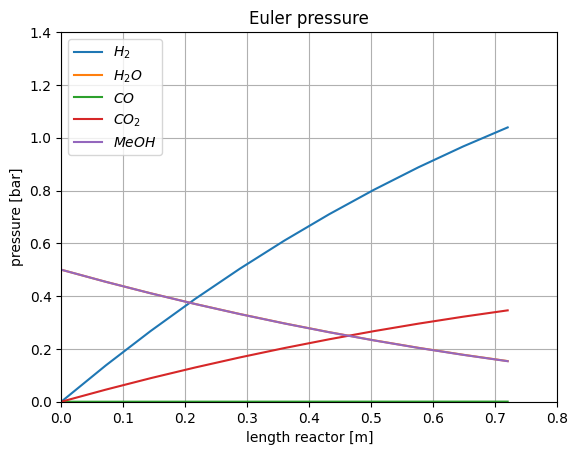

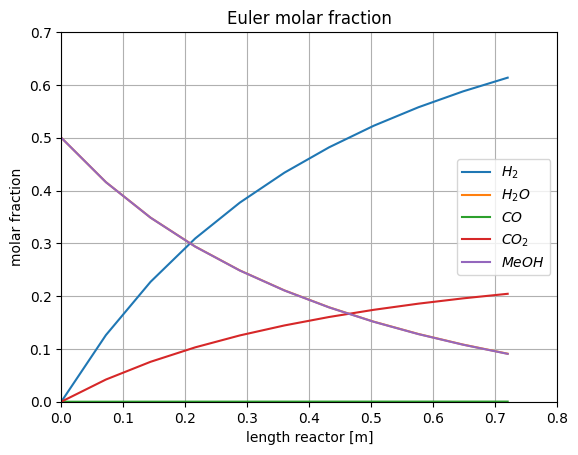

In [175]:
# @title full plot

'''
plots both reactors in the cascade using euler's method and the runge kutta method
'''

plt.figure(1)
plt.plot(pEul[:,5], pEul[:,0], label='$H_2$')
plt.plot(pEul[:,5], pEul[:,1], label='$H_2O$')
plt.plot(pEul[:,5], pEul[:,2], label='$CO$')
plt.plot(pEul[:,5], pEul[:,3], label='$CO_2$')
plt.plot(pEul[:,5], pEul[:,4], label='$MeOH$')
plt.title("Euler pressure")
plt.axis((0, 0.800, 0, 1.40))
plt.legend(loc='best')
plt.grid()
plt.xlabel("length reactor [m]")
plt.ylabel ("pressure [bar]")

plt.figure(2)
plt.plot(pEulfrac[:,5], pEulfrac[:,0], label='$H_2$')
plt.plot(pEulfrac[:,5], pEulfrac[:,1], label='$H_2O$')
plt.plot(pEulfrac[:,5], pEulfrac[:,2], label='$CO$')
plt.plot(pEulfrac[:,5], pEulfrac[:,3], label='$CO_2$')
plt.plot(pEulfrac[:,5], pEulfrac[:,4], label='$MeOH$')
plt.title("Euler molar fraction")
plt.axis((0, 0.800, 0, 0.7))
plt.legend(loc='best')
plt.grid()
plt.xlabel("length reactor [m]")
plt.ylabel ("molar fraction")

# main temp loop and comparison

In [185]:
# @title main temp loop

'''
contains main function to call all other relevant functions and set temperature and reaction index
'''

Temp_min = 140                                                            # minimum temperature boundary [°C]
Temp_max = 170                                                            # maximum temperature boundary [°C]

T_min = Temp_min + 273                                                    # minimum temperature boundary [K]
T_max = Temp_max + 273                                                    # maximum temperature boundary [K]
T_stepsize = 5                                                            # temperature change per loop iteration [K]
T_points = int((T_max - T_min ) / T_stepsize + 1)                         # number of array points pointing to temperatures
temperature_arr = np.arange(0, T_points)*T_stepsize + T_min               # sets temperature array to be examined
pEulTemps = np.zeros([T_points, len(m_cat_span), len(IC)])

for i in range (T_points):
  T = temperature_arr [i]                                                 # reactor temperature [K]
  VFlow = n_Flow_total*R*T/(p_in * np.power(10, 5, dtype = float))        # volumetric flowrate [m^3 h^-1]
  pEulTemps [i, :, :] = EulFun(IC, T, VFlow)
  pEulTemps [i, :, 5] = pEulTemps [i, :, 5] / dens_cat / A_R

  for l in range(steps+1):
    n_ges = np.sum(pEulTemps[i, l, :-1]) * R * T / VFlow / 100
    for j in range(5):
      pEulTemps[i, l, j] = pEulTemps[i, l, j] * R * T / VFlow / 100
      pEulTemps[i, l, j] = pEulTemps[i, l, j]/n_ges
# print (pEulTemps)
# print (temperature_arr)

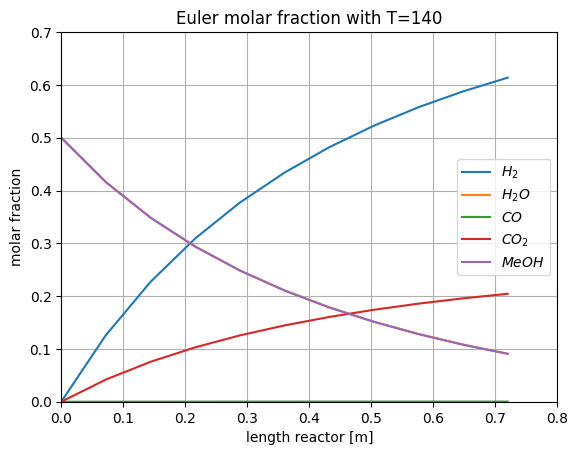

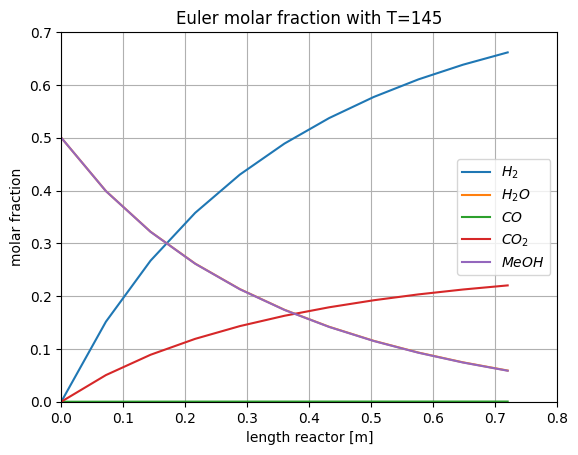

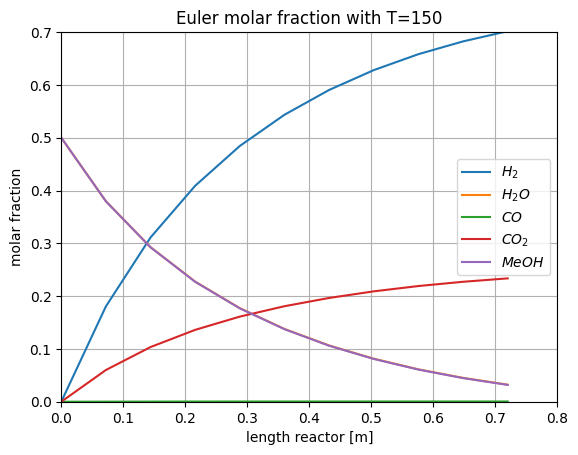

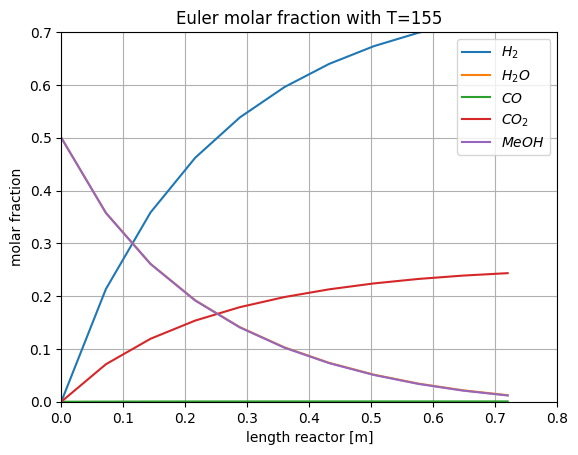

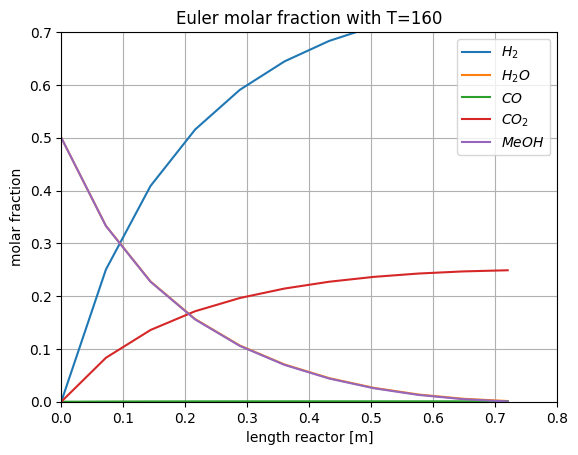

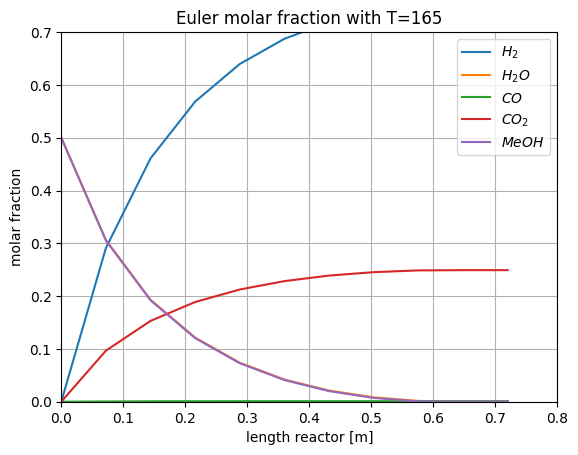

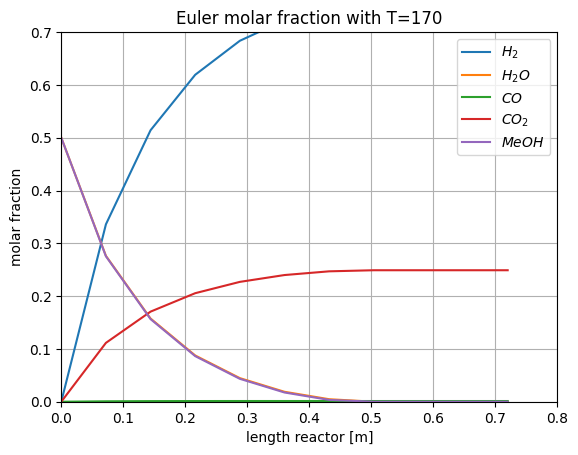

In [188]:
# @title main temp loop plots

for i in range (T_points):
  plt.figure(i)
  t = temperature_arr[i]-273
  plt.plot(pEulTemps[i, :, 5], pEulTemps[i, :, 0], label='$H_2$')
  plt.plot(pEulTemps[i, :, 5], pEulTemps[i, :, 1], label='$H_2O$')
  plt.plot(pEulTemps[i, :, 5], pEulTemps[i, :, 2], label='$CO$')
  plt.plot(pEulTemps[i, :, 5], pEulTemps[i, :, 3], label='$CO_2$')
  plt.plot(pEulTemps[i, :, 5], pEulTemps[i, :, 4], label='$MeOH$')
  plt.title('Euler molar fraction with T=%i' %t)
  plt.axis((0, 0.800, 0, 0.7))
  plt.legend(loc='best')
  plt.grid()
  plt.xlabel("length reactor [m]")
  plt.ylabel ("molar fraction")